## Step 1: Imports and Setup

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import os

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set random seed
torch.manual_seed(42)
np.random.seed(42)

Using device: cpu


## Step 2: Adversarial Autoencoder Model

In [3]:
class AdversarialAutoencoder(nn.Module):
    """
    Adversarial Autoencoder (Makhzani et al., ICLR 2016)

    Key idea: Use adversarial training to match the aggregated posterior
    of the latent space with an arbitrary prior distribution.
    """

    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=20, prior_type='gaussian'):
        super(AdversarialAutoencoder, self).__init__()

        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.prior_type = prior_type

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
        )

        # Latent representation
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )

        # Discriminator (for adversarial training)
        self.discriminator = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )

    def encode(self, x):
        """Encode input to latent parameters"""
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        """Reparameterization trick"""
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        """Decode latent vector to reconstruction"""
        return self.decoder(z)

    def forward(self, x):
        """Forward pass"""
        mu, logvar = self.encode(x.view(-1, self.input_dim))
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar, z

    def generate_from_prior(self, num_samples):
        """Generate samples from prior distribution"""
        if self.prior_type == 'gaussian':
            z = torch.randn(num_samples, self.latent_dim).to(device)
        elif self.prior_type == 'uniform':
            z = torch.rand(num_samples, self.latent_dim).to(device) * 2 - 1  # [-1, 1]

        generated = self.decode(z)
        return generated

    def discriminate(self, z):
        """Discriminate between real prior and encoded samples"""
        return self.discriminator(z)

## Step 3: Training Function with Adversarial Loss


In [4]:
def train_adversarial_autoencoder(model, train_loader, epochs=100, lr=1e-3):
    """
    Train Adversarial Autoencoder with alternating optimization
    """

    # Three optimizers: for encoder/decoder, generator, and discriminator
    ae_optimizer = optim.Adam(
        list(model.encoder.parameters()) + list(model.decoder.parameters()),
        lr=lr
    )
    discriminator_optimizer = optim.Adam(model.discriminator.parameters(), lr=lr)

    # Loss functions
    reconstruction_criterion = nn.BCELoss()
    adversarial_criterion = nn.BCELoss()

    model.to(device)

    ae_losses = []
    disc_losses = []
    gen_losses = []

    print("Starting Adversarial Autoencoder Training...")
    print("=" * 60)

    for epoch in range(epochs):
        model.train()
        epoch_ae_loss = 0.0
        epoch_disc_loss = 0.0
        epoch_gen_loss = 0.0

        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}')

        for batch_idx, (data, _) in enumerate(pbar):
            data = data.to(device).view(-1, 784)
            batch_size = data.size(0)

            # ==================== #
            # 1. Train Discriminator #
            # ==================== #

            discriminator_optimizer.zero_grad()

            # Real samples from prior
            if model.prior_type == 'gaussian':
                real_z = torch.randn(batch_size, model.latent_dim).to(device)
            else:  # uniform
                real_z = torch.rand(batch_size, model.latent_dim).to(device) * 2 - 1

            real_labels = torch.ones(batch_size, 1).to(device)
            fake_labels = torch.zeros(batch_size, 1).to(device)

            # Fake samples from encoder
            with torch.no_grad():
                _, _, _, fake_z = model(data)

            # Discriminator loss
            real_loss = adversarial_criterion(model.discriminate(real_z), real_labels)
            fake_loss = adversarial_criterion(model.discriminate(fake_z.detach()), fake_labels)
            disc_loss = (real_loss + fake_loss) / 2

            disc_loss.backward()
            discriminator_optimizer.step()

            # =========================== #
            # 2. Train Generator (Encoder) #
            # =========================== #

            ae_optimizer.zero_grad()

            # Reconstruction loss
            recon_batch, mu, logvar, fake_z = model(data)
            recon_loss = reconstruction_criterion(recon_batch, data)

            # Generator loss (fool discriminator)
            gen_loss = adversarial_criterion(model.discriminate(fake_z), real_labels)

            # Total AE loss = reconstruction + adversarial
            total_ae_loss = recon_loss + gen_loss

            total_ae_loss.backward()
            ae_optimizer.step()

            # Accumulate losses
            epoch_ae_loss += total_ae_loss.item()
            epoch_disc_loss += disc_loss.item()
            epoch_gen_loss += gen_loss.item()

            pbar.set_postfix({
                'AE Loss': f'{total_ae_loss.item():.3f}',
                'Disc Loss': f'{disc_loss.item():.3f}',
                'Gen Loss': f'{gen_loss.item():.3f}'
            })

        # Calculate averages
        avg_ae_loss = epoch_ae_loss / len(train_loader)
        avg_disc_loss = epoch_disc_loss / len(train_loader)
        avg_gen_loss = epoch_gen_loss / len(train_loader)

        ae_losses.append(avg_ae_loss)
        disc_losses.append(avg_disc_loss)
        gen_losses.append(avg_gen_loss)

        print(f'Epoch {epoch+1}: AE: {avg_ae_loss:.3f}, Disc: {avg_disc_loss:.3f}, Gen: {avg_gen_loss:.3f}')

    return ae_losses, disc_losses, gen_losses

## Step 4: Visualization Functions


In [5]:
def plot_training_curves(ae_losses, disc_losses, gen_losses):
    """Plot training progress"""
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.plot(ae_losses)
    plt.title('Autoencoder Loss')
    plt.xlabel('Epoch')
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 3, 2)
    plt.plot(disc_losses)
    plt.title('Discriminator Loss')
    plt.xlabel('Epoch')
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 3, 3)
    plt.plot(gen_losses)
    plt.title('Generator Loss')
    plt.xlabel('Epoch')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def visualize_reconstructions(model, test_loader, num_samples=8):
    """Visualize original vs reconstructed images"""
    model.eval()

    data, _ = next(iter(test_loader))
    data = data[:num_samples].to(device)

    with torch.no_grad():
        reconstructions, _, _, _ = model(data.view(-1, 784))

    # Plot
    fig, axes = plt.subplots(2, num_samples, figsize=(12, 4))

    for i in range(num_samples):
        # Original
        axes[0, i].imshow(data[i].cpu().squeeze(), cmap='gray')
        axes[0, i].set_title('Original')
        axes[0, i].axis('off')

        # Reconstruction
        axes[1, i].imshow(reconstructions[i].cpu().view(28, 28), cmap='gray')
        axes[1, i].set_title('Reconstructed')
        axes[1, i].axis('off')

    plt.suptitle('Adversarial Autoencoder Reconstructions')
    plt.tight_layout()
    plt.show()

def visualize_prior_generation(model, num_samples=25):
    """Generate samples from prior distribution"""
    model.eval()

    with torch.no_grad():
        generated = model.generate_from_prior(num_samples)

    # Plot in grid
    grid_size = int(np.sqrt(num_samples))
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(8, 8))

    for i, ax in enumerate(axes.flat):
        if i < num_samples:
            img = generated[i].cpu().view(28, 28)
            ax.imshow(img, cmap='gray')
        ax.axis('off')

    plt.suptitle(f'Samples from {model.prior_type.capitalize()} Prior')
    plt.tight_layout()
    plt.show()

def latent_space_interpolation(model, test_loader, num_points=10):
    """Interpolate between two points in latent space"""
    model.eval()

    # Get two random samples
    data, _ = next(iter(test_loader))
    data = data[:2].to(device)

    with torch.no_grad():
        mu1, _ = model.encode(data[0].view(1, -1))
        mu2, _ = model.encode(data[1].view(1, -1))

        # Interpolate in latent space
        interpolations = []
        for alpha in np.linspace(0, 1, num_points):
            z = alpha * mu1 + (1 - alpha) * mu2
            reconstruction = model.decode(z)
            interpolations.append(reconstruction.cpu())

    # Plot interpolation
    fig, axes = plt.subplots(1, num_points, figsize=(15, 2))

    for i, ax in enumerate(axes):
        ax.imshow(interpolations[i].view(28, 28), cmap='gray')
        ax.set_title(f'α={i/(num_points-1):.1f}')
        ax.axis('off')

    plt.suptitle('Latent Space Interpolation')
    plt.tight_layout()
    plt.show()

## Step 5: Discriminator Analysis

In [6]:
def analyze_latent_distribution(model, test_loader):
    """Analyze how well the latent distribution matches the prior"""
    model.eval()

    all_latents = []

    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(device)
            _, _, _, z = model(data.view(-1, 784))
            all_latents.append(z.cpu())

    all_latents = torch.cat(all_latents)

    # Plot latent distribution
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))

    for i in range(min(10, model.latent_dim)):
        ax = axes[i//5, i%5]
        ax.hist(all_latents[:, i].numpy(), bins=50, alpha=0.7, density=True)

        if model.prior_type == 'gaussian':
            # Plot standard normal for comparison
            x = np.linspace(-4, 4, 100)
            ax.plot(x, 1/np.sqrt(2*np.pi) * np.exp(-0.5*x**2), 'r-', linewidth=2)
        else:  # uniform
            ax.axhline(y=0.5, color='r', linestyle='-', linewidth=2)

        ax.set_title(f'Latent Dim {i}')
        ax.grid(True, alpha=0.3)

    plt.suptitle(f'Latent Distribution vs {model.prior_type.capitalize()} Prior')
    plt.tight_layout()
    plt.show()

    # Print statistics
    print("Latent Distribution Statistics:")
    print(f"Mean: {all_latents.mean(0)}")
    print(f"Std: {all_latents.std(0)}")

## Step 6: Main Training Script


100%|██████████| 9.91M/9.91M [00:00<00:00, 39.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.07MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 9.73MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.03MB/s]


Training samples: 60000
Test samples: 10000

Training Adversarial Autoencoder with gaussian prior
Starting Adversarial Autoencoder Training...


Epoch 1/50: 100%|██████████| 469/469 [00:36<00:00, 12.75it/s, AE Loss=0.963, Disc Loss=0.696, Gen Loss=0.698]


Epoch 1: AE: 0.970, Disc: 0.694, Gen: 0.699


Epoch 2/50: 100%|██████████| 469/469 [00:35<00:00, 13.31it/s, AE Loss=0.962, Disc Loss=0.695, Gen Loss=0.689]


Epoch 2: AE: 0.957, Disc: 0.693, Gen: 0.693


Epoch 3/50: 100%|██████████| 469/469 [00:37<00:00, 12.49it/s, AE Loss=0.962, Disc Loss=0.694, Gen Loss=0.699]


Epoch 3: AE: 0.963, Disc: 0.693, Gen: 0.700


Epoch 4/50: 100%|██████████| 469/469 [00:37<00:00, 12.36it/s, AE Loss=0.955, Disc Loss=0.694, Gen Loss=0.688]


Epoch 4: AE: 0.961, Disc: 0.693, Gen: 0.697


Epoch 5/50: 100%|██████████| 469/469 [00:38<00:00, 12.31it/s, AE Loss=0.959, Disc Loss=0.693, Gen Loss=0.694]


Epoch 5: AE: 0.958, Disc: 0.693, Gen: 0.694


Epoch 6/50: 100%|██████████| 469/469 [00:38<00:00, 12.20it/s, AE Loss=0.960, Disc Loss=0.694, Gen Loss=0.697]


Epoch 6: AE: 0.958, Disc: 0.693, Gen: 0.695


Epoch 7/50: 100%|██████████| 469/469 [00:38<00:00, 12.12it/s, AE Loss=0.968, Disc Loss=0.695, Gen Loss=0.701]


Epoch 7: AE: 0.973, Disc: 0.693, Gen: 0.710


Epoch 8/50: 100%|██████████| 469/469 [00:38<00:00, 12.22it/s, AE Loss=0.963, Disc Loss=0.690, Gen Loss=0.699]


Epoch 8: AE: 0.957, Disc: 0.693, Gen: 0.694


Epoch 9/50: 100%|██████████| 469/469 [00:38<00:00, 12.06it/s, AE Loss=0.943, Disc Loss=0.693, Gen Loss=0.685]


Epoch 9: AE: 0.959, Disc: 0.693, Gen: 0.696


Epoch 10/50: 100%|██████████| 469/469 [00:41<00:00, 11.28it/s, AE Loss=0.961, Disc Loss=0.690, Gen Loss=0.693]


Epoch 10: AE: 0.957, Disc: 0.693, Gen: 0.694


Epoch 11/50: 100%|██████████| 469/469 [00:39<00:00, 11.99it/s, AE Loss=0.965, Disc Loss=0.692, Gen Loss=0.699]


Epoch 11: AE: 0.962, Disc: 0.693, Gen: 0.699


Epoch 12/50: 100%|██████████| 469/469 [00:39<00:00, 11.96it/s, AE Loss=0.962, Disc Loss=0.693, Gen Loss=0.690]


Epoch 12: AE: 0.956, Disc: 0.693, Gen: 0.692


Epoch 13/50: 100%|██████████| 469/469 [00:39<00:00, 11.83it/s, AE Loss=0.959, Disc Loss=0.691, Gen Loss=0.684]


Epoch 13: AE: 0.968, Disc: 0.693, Gen: 0.705


Epoch 14/50: 100%|██████████| 469/469 [00:39<00:00, 11.84it/s, AE Loss=0.951, Disc Loss=0.688, Gen Loss=0.688]


Epoch 14: AE: 0.957, Disc: 0.693, Gen: 0.694


Epoch 15/50: 100%|██████████| 469/469 [00:40<00:00, 11.67it/s, AE Loss=0.958, Disc Loss=0.690, Gen Loss=0.693]


Epoch 15: AE: 0.959, Disc: 0.693, Gen: 0.696


Epoch 16/50: 100%|██████████| 469/469 [00:40<00:00, 11.66it/s, AE Loss=0.947, Disc Loss=0.692, Gen Loss=0.695]


Epoch 16: AE: 0.962, Disc: 0.693, Gen: 0.699


Epoch 17/50: 100%|██████████| 469/469 [00:40<00:00, 11.58it/s, AE Loss=0.975, Disc Loss=0.693, Gen Loss=0.702]


Epoch 17: AE: 0.957, Disc: 0.693, Gen: 0.694


Epoch 18/50: 100%|██████████| 469/469 [00:43<00:00, 10.90it/s, AE Loss=0.955, Disc Loss=0.689, Gen Loss=0.694]


Epoch 18: AE: 0.957, Disc: 0.693, Gen: 0.694


Epoch 19/50: 100%|██████████| 469/469 [00:40<00:00, 11.49it/s, AE Loss=0.945, Disc Loss=0.695, Gen Loss=0.684]


Epoch 19: AE: 0.966, Disc: 0.693, Gen: 0.703


Epoch 20/50: 100%|██████████| 469/469 [00:40<00:00, 11.54it/s, AE Loss=0.963, Disc Loss=0.691, Gen Loss=0.696]


Epoch 20: AE: 0.958, Disc: 0.693, Gen: 0.695


Epoch 21/50: 100%|██████████| 469/469 [00:40<00:00, 11.50it/s, AE Loss=0.956, Disc Loss=0.694, Gen Loss=0.692]


Epoch 21: AE: 0.958, Disc: 0.692, Gen: 0.695


Epoch 22/50: 100%|██████████| 469/469 [00:40<00:00, 11.55it/s, AE Loss=0.959, Disc Loss=0.689, Gen Loss=0.699]


Epoch 22: AE: 0.958, Disc: 0.693, Gen: 0.695


Epoch 23/50: 100%|██████████| 469/469 [00:41<00:00, 11.37it/s, AE Loss=0.965, Disc Loss=0.693, Gen Loss=0.695]


Epoch 23: AE: 0.958, Disc: 0.693, Gen: 0.695


Epoch 24/50: 100%|██████████| 469/469 [00:41<00:00, 11.37it/s, AE Loss=0.967, Disc Loss=0.693, Gen Loss=0.697]


Epoch 24: AE: 0.958, Disc: 0.693, Gen: 0.695


Epoch 25/50: 100%|██████████| 469/469 [00:40<00:00, 11.54it/s, AE Loss=0.975, Disc Loss=0.692, Gen Loss=0.700]


Epoch 25: AE: 0.959, Disc: 0.693, Gen: 0.696


Epoch 26/50: 100%|██████████| 469/469 [00:42<00:00, 10.99it/s, AE Loss=0.964, Disc Loss=0.692, Gen Loss=0.700]


Epoch 26: AE: 0.959, Disc: 0.693, Gen: 0.696


Epoch 27/50: 100%|██████████| 469/469 [00:40<00:00, 11.57it/s, AE Loss=0.961, Disc Loss=0.694, Gen Loss=0.700]


Epoch 27: AE: 0.959, Disc: 0.692, Gen: 0.696


Epoch 28/50: 100%|██████████| 469/469 [00:40<00:00, 11.54it/s, AE Loss=0.956, Disc Loss=0.692, Gen Loss=0.692]


Epoch 28: AE: 0.959, Disc: 0.692, Gen: 0.697


Epoch 29/50: 100%|██████████| 469/469 [00:40<00:00, 11.53it/s, AE Loss=0.962, Disc Loss=0.694, Gen Loss=0.702]


Epoch 29: AE: 0.959, Disc: 0.693, Gen: 0.696


Epoch 30/50: 100%|██████████| 469/469 [00:40<00:00, 11.54it/s, AE Loss=0.958, Disc Loss=0.693, Gen Loss=0.697]


Epoch 30: AE: 0.958, Disc: 0.692, Gen: 0.695


Epoch 31/50: 100%|██████████| 469/469 [00:41<00:00, 11.40it/s, AE Loss=0.959, Disc Loss=0.694, Gen Loss=0.690]


Epoch 31: AE: 0.959, Disc: 0.692, Gen: 0.696


Epoch 32/50: 100%|██████████| 469/469 [00:41<00:00, 11.37it/s, AE Loss=0.959, Disc Loss=0.698, Gen Loss=0.693]


Epoch 32: AE: 0.958, Disc: 0.692, Gen: 0.695


Epoch 33/50: 100%|██████████| 469/469 [00:41<00:00, 11.28it/s, AE Loss=0.967, Disc Loss=0.692, Gen Loss=0.694]


Epoch 33: AE: 0.959, Disc: 0.692, Gen: 0.696


Epoch 34/50: 100%|██████████| 469/469 [00:43<00:00, 10.90it/s, AE Loss=0.960, Disc Loss=0.696, Gen Loss=0.699]


Epoch 34: AE: 0.959, Disc: 0.692, Gen: 0.696


Epoch 35/50: 100%|██████████| 469/469 [00:40<00:00, 11.57it/s, AE Loss=0.962, Disc Loss=0.689, Gen Loss=0.698]


Epoch 35: AE: 0.959, Disc: 0.692, Gen: 0.696


Epoch 36/50: 100%|██████████| 469/469 [00:40<00:00, 11.53it/s, AE Loss=0.945, Disc Loss=0.693, Gen Loss=0.689]


Epoch 36: AE: 0.959, Disc: 0.692, Gen: 0.696


Epoch 37/50: 100%|██████████| 469/469 [00:40<00:00, 11.53it/s, AE Loss=0.971, Disc Loss=0.691, Gen Loss=0.698]


Epoch 37: AE: 0.959, Disc: 0.692, Gen: 0.696


Epoch 38/50: 100%|██████████| 469/469 [00:40<00:00, 11.58it/s, AE Loss=0.954, Disc Loss=0.689, Gen Loss=0.694]


Epoch 38: AE: 0.959, Disc: 0.692, Gen: 0.697


Epoch 39/50: 100%|██████████| 469/469 [00:40<00:00, 11.51it/s, AE Loss=0.966, Disc Loss=0.691, Gen Loss=0.702]


Epoch 39: AE: 0.960, Disc: 0.692, Gen: 0.697


Epoch 40/50: 100%|██████████| 469/469 [00:40<00:00, 11.54it/s, AE Loss=0.962, Disc Loss=0.698, Gen Loss=0.696]


Epoch 40: AE: 0.959, Disc: 0.692, Gen: 0.696


Epoch 41/50: 100%|██████████| 469/469 [00:42<00:00, 11.13it/s, AE Loss=0.952, Disc Loss=0.691, Gen Loss=0.696]


Epoch 41: AE: 0.960, Disc: 0.692, Gen: 0.697


Epoch 42/50: 100%|██████████| 469/469 [00:42<00:00, 10.98it/s, AE Loss=0.969, Disc Loss=0.688, Gen Loss=0.694]


Epoch 42: AE: 0.960, Disc: 0.692, Gen: 0.697


Epoch 43/50: 100%|██████████| 469/469 [00:40<00:00, 11.54it/s, AE Loss=0.947, Disc Loss=0.693, Gen Loss=0.694]


Epoch 43: AE: 0.959, Disc: 0.692, Gen: 0.697


Epoch 44/50: 100%|██████████| 469/469 [00:40<00:00, 11.54it/s, AE Loss=0.953, Disc Loss=0.691, Gen Loss=0.696]


Epoch 44: AE: 0.959, Disc: 0.692, Gen: 0.696


Epoch 45/50: 100%|██████████| 469/469 [00:40<00:00, 11.46it/s, AE Loss=0.961, Disc Loss=0.695, Gen Loss=0.702]


Epoch 45: AE: 0.960, Disc: 0.692, Gen: 0.697


Epoch 46/50: 100%|██████████| 469/469 [00:40<00:00, 11.50it/s, AE Loss=0.968, Disc Loss=0.693, Gen Loss=0.698]


Epoch 46: AE: 0.960, Disc: 0.692, Gen: 0.697


Epoch 47/50: 100%|██████████| 469/469 [00:40<00:00, 11.52it/s, AE Loss=0.956, Disc Loss=0.686, Gen Loss=0.698]


Epoch 47: AE: 0.960, Disc: 0.692, Gen: 0.697


Epoch 48/50: 100%|██████████| 469/469 [00:40<00:00, 11.51it/s, AE Loss=0.959, Disc Loss=0.695, Gen Loss=0.690]


Epoch 48: AE: 0.961, Disc: 0.692, Gen: 0.698


Epoch 49/50: 100%|██████████| 469/469 [00:43<00:00, 10.87it/s, AE Loss=0.954, Disc Loss=0.690, Gen Loss=0.690]


Epoch 49: AE: 0.960, Disc: 0.692, Gen: 0.697


Epoch 50/50: 100%|██████████| 469/469 [00:40<00:00, 11.54it/s, AE Loss=0.961, Disc Loss=0.688, Gen Loss=0.697]


Epoch 50: AE: 0.960, Disc: 0.692, Gen: 0.697


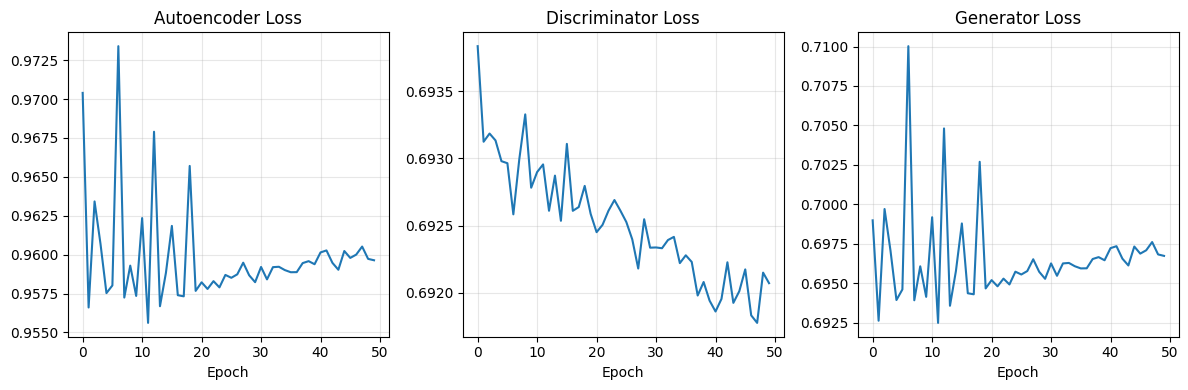

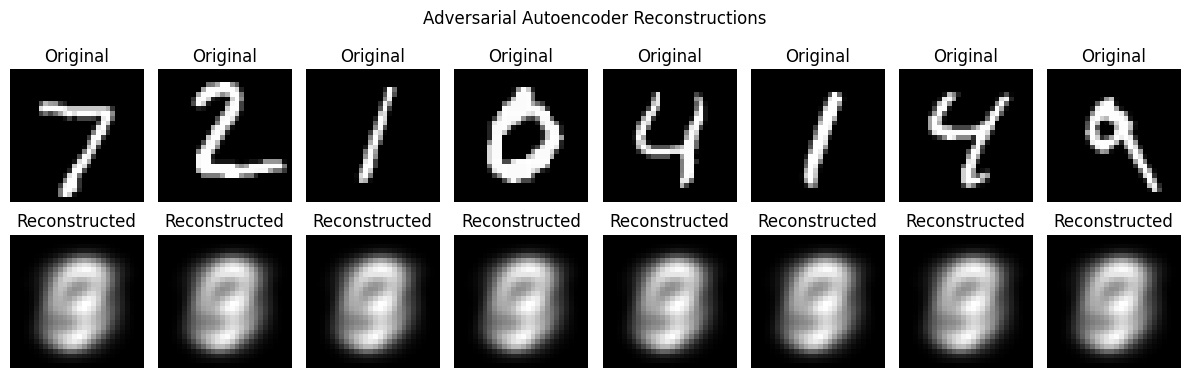

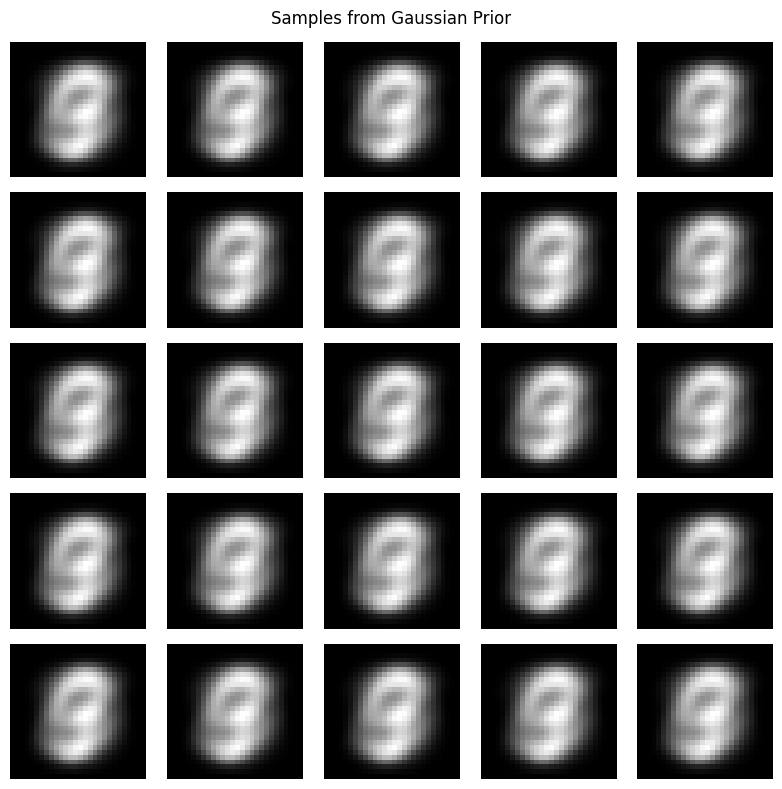

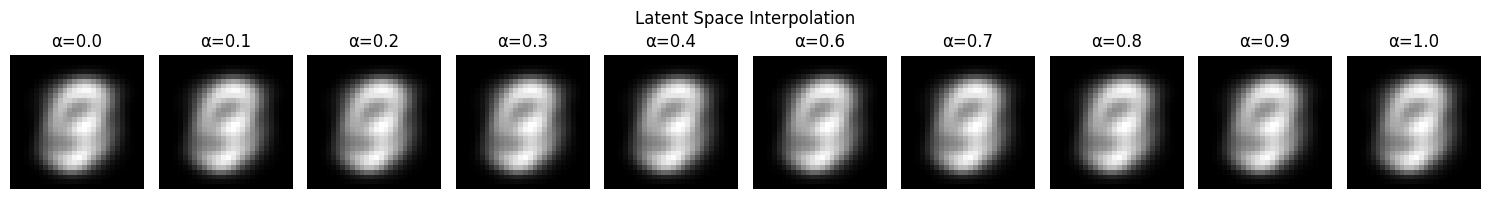

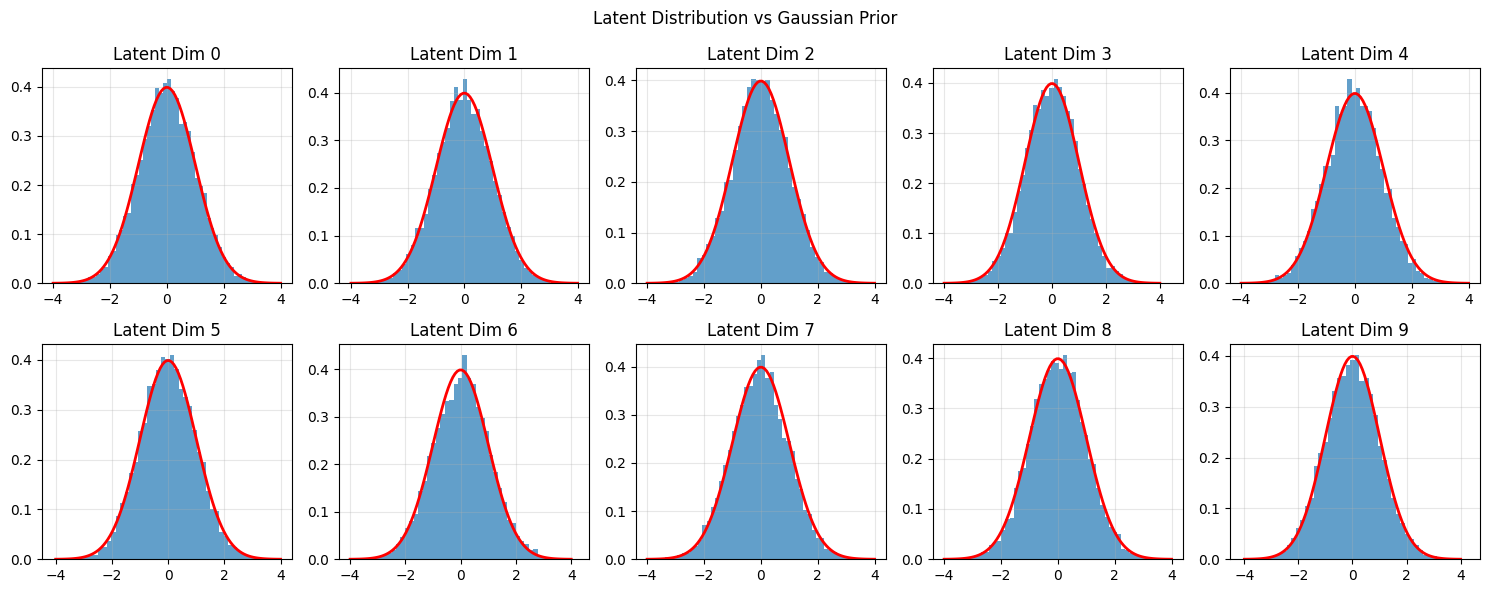

Latent Distribution Statistics:
Mean: tensor([ 0.0182, -0.0062, -0.0012,  0.0131, -0.0353, -0.0009,  0.0341, -0.0368,
         0.0034, -0.0182,  0.0216,  0.0097, -0.0012,  0.0109, -0.0171, -0.0140,
         0.0092,  0.0129,  0.0371, -0.0082])
Std: tensor([1.0013, 0.9908, 0.9876, 0.9805, 0.9905, 0.9871, 1.0245, 1.0033, 0.9873,
        1.0141, 1.0094, 0.9702, 0.9902, 1.0043, 0.9831, 1.0098, 0.9869, 0.9988,
        0.9886, 1.0187])

Training Adversarial Autoencoder with uniform prior
Starting Adversarial Autoencoder Training...


Epoch 1/50: 100%|██████████| 469/469 [00:33<00:00, 13.88it/s, AE Loss=1.640, Disc Loss=0.574, Gen Loss=1.378]


Epoch 1: AE: 2.174, Disc: 0.608, Gen: 1.902


Epoch 2/50: 100%|██████████| 469/469 [00:38<00:00, 12.17it/s, AE Loss=1.023, Disc Loss=0.900, Gen Loss=0.755]


Epoch 2: AE: 1.085, Disc: 0.695, Gen: 0.824


Epoch 3/50: 100%|██████████| 469/469 [00:39<00:00, 11.79it/s, AE Loss=1.172, Disc Loss=0.681, Gen Loss=0.906]


Epoch 3: AE: 1.120, Disc: 0.659, Gen: 0.860


Epoch 4/50: 100%|██████████| 469/469 [00:39<00:00, 11.77it/s, AE Loss=1.271, Disc Loss=0.621, Gen Loss=1.010]


Epoch 4: AE: 1.277, Disc: 0.633, Gen: 1.016


Epoch 5/50: 100%|██████████| 469/469 [00:40<00:00, 11.71it/s, AE Loss=1.308, Disc Loss=0.589, Gen Loss=1.043]


Epoch 5: AE: 1.292, Disc: 0.621, Gen: 1.031


Epoch 6/50: 100%|██████████| 469/469 [00:40<00:00, 11.68it/s, AE Loss=1.273, Disc Loss=0.613, Gen Loss=1.017]


Epoch 6: AE: 1.311, Disc: 0.623, Gen: 1.051


Epoch 7/50: 100%|██████████| 469/469 [00:42<00:00, 10.95it/s, AE Loss=1.261, Disc Loss=0.644, Gen Loss=1.017]


Epoch 7: AE: 1.291, Disc: 0.627, Gen: 1.032


Epoch 8/50: 100%|██████████| 469/469 [00:40<00:00, 11.61it/s, AE Loss=1.447, Disc Loss=0.620, Gen Loss=1.183]


Epoch 8: AE: 1.283, Disc: 0.629, Gen: 1.024


Epoch 9/50: 100%|██████████| 469/469 [00:40<00:00, 11.46it/s, AE Loss=1.188, Disc Loss=0.577, Gen Loss=0.932]


Epoch 9: AE: 1.280, Disc: 0.629, Gen: 1.021


Epoch 10/50: 100%|██████████| 469/469 [00:40<00:00, 11.44it/s, AE Loss=1.385, Disc Loss=0.573, Gen Loss=1.133]


Epoch 10: AE: 1.281, Disc: 0.619, Gen: 1.022


Epoch 11/50: 100%|██████████| 469/469 [00:41<00:00, 11.33it/s, AE Loss=1.690, Disc Loss=0.525, Gen Loss=1.413]


Epoch 11: AE: 1.347, Disc: 0.596, Gen: 1.089


Epoch 12/50: 100%|██████████| 469/469 [00:41<00:00, 11.27it/s, AE Loss=1.637, Disc Loss=0.537, Gen Loss=1.382]


Epoch 12: AE: 1.452, Disc: 0.577, Gen: 1.194


Epoch 13/50: 100%|██████████| 469/469 [00:41<00:00, 11.23it/s, AE Loss=1.725, Disc Loss=0.560, Gen Loss=1.462]


Epoch 13: AE: 1.510, Disc: 0.552, Gen: 1.255


Epoch 14/50: 100%|██████████| 469/469 [00:44<00:00, 10.54it/s, AE Loss=1.592, Disc Loss=0.583, Gen Loss=1.350]


Epoch 14: AE: 1.621, Disc: 0.524, Gen: 1.367


Epoch 15/50: 100%|██████████| 469/469 [00:41<00:00, 11.18it/s, AE Loss=1.830, Disc Loss=0.470, Gen Loss=1.571]


Epoch 15: AE: 1.780, Disc: 0.492, Gen: 1.530


Epoch 16/50: 100%|██████████| 469/469 [00:42<00:00, 11.09it/s, AE Loss=2.078, Disc Loss=0.412, Gen Loss=1.822]


Epoch 16: AE: 1.963, Disc: 0.456, Gen: 1.714


Epoch 17/50: 100%|██████████| 469/469 [00:42<00:00, 11.15it/s, AE Loss=2.172, Disc Loss=0.373, Gen Loss=1.924]


Epoch 17: AE: 2.222, Disc: 0.410, Gen: 1.975


Epoch 18/50: 100%|██████████| 469/469 [00:42<00:00, 11.09it/s, AE Loss=2.522, Disc Loss=0.373, Gen Loss=2.278]


Epoch 18: AE: 2.376, Disc: 0.381, Gen: 2.133


Epoch 19/50: 100%|██████████| 469/469 [00:42<00:00, 11.01it/s, AE Loss=3.099, Disc Loss=0.427, Gen Loss=2.852]


Epoch 19: AE: 2.648, Disc: 0.352, Gen: 2.405


Epoch 20/50: 100%|██████████| 469/469 [00:43<00:00, 10.89it/s, AE Loss=3.078, Disc Loss=0.300, Gen Loss=2.845]


Epoch 20: AE: 2.814, Disc: 0.328, Gen: 2.572


Epoch 21/50: 100%|██████████| 469/469 [00:44<00:00, 10.59it/s, AE Loss=3.262, Disc Loss=0.247, Gen Loss=3.026]


Epoch 21: AE: 2.950, Disc: 0.312, Gen: 2.715


Epoch 22/50: 100%|██████████| 469/469 [00:43<00:00, 10.90it/s, AE Loss=3.309, Disc Loss=0.285, Gen Loss=3.076]


Epoch 22: AE: 3.157, Disc: 0.296, Gen: 2.923


Epoch 23/50: 100%|██████████| 469/469 [00:42<00:00, 11.10it/s, AE Loss=3.593, Disc Loss=0.270, Gen Loss=3.378]


Epoch 23: AE: 3.265, Disc: 0.284, Gen: 3.033


Epoch 24/50: 100%|██████████| 469/469 [00:42<00:00, 11.06it/s, AE Loss=3.274, Disc Loss=0.237, Gen Loss=3.047]


Epoch 24: AE: 3.357, Disc: 0.276, Gen: 3.127


Epoch 25/50: 100%|██████████| 469/469 [00:42<00:00, 11.06it/s, AE Loss=3.724, Disc Loss=0.240, Gen Loss=3.497]


Epoch 25: AE: 3.470, Disc: 0.262, Gen: 3.240


Epoch 26/50: 100%|██████████| 469/469 [00:43<00:00, 10.82it/s, AE Loss=3.434, Disc Loss=0.214, Gen Loss=3.206]


Epoch 26: AE: 3.551, Disc: 0.256, Gen: 3.322


Epoch 27/50: 100%|██████████| 469/469 [00:42<00:00, 10.95it/s, AE Loss=3.784, Disc Loss=0.148, Gen Loss=3.548]


Epoch 27: AE: 3.667, Disc: 0.246, Gen: 3.440


Epoch 28/50: 100%|██████████| 469/469 [00:43<00:00, 10.76it/s, AE Loss=4.208, Disc Loss=0.189, Gen Loss=3.981]


Epoch 28: AE: 3.797, Disc: 0.240, Gen: 3.569


Epoch 29/50: 100%|██████████| 469/469 [00:43<00:00, 10.82it/s, AE Loss=3.663, Disc Loss=0.284, Gen Loss=3.431]


Epoch 29: AE: 3.775, Disc: 0.240, Gen: 3.548


Epoch 30/50: 100%|██████████| 469/469 [00:42<00:00, 11.08it/s, AE Loss=4.322, Disc Loss=0.200, Gen Loss=4.089]


Epoch 30: AE: 3.876, Disc: 0.234, Gen: 3.649


Epoch 31/50: 100%|██████████| 469/469 [00:42<00:00, 11.11it/s, AE Loss=3.829, Disc Loss=0.177, Gen Loss=3.610]


Epoch 31: AE: 3.886, Disc: 0.230, Gen: 3.661


Epoch 32/50: 100%|██████████| 469/469 [00:42<00:00, 11.08it/s, AE Loss=4.175, Disc Loss=0.220, Gen Loss=3.957]


Epoch 32: AE: 3.973, Disc: 0.224, Gen: 3.751


Epoch 33/50: 100%|██████████| 469/469 [00:42<00:00, 11.06it/s, AE Loss=3.860, Disc Loss=0.193, Gen Loss=3.648]


Epoch 33: AE: 4.085, Disc: 0.219, Gen: 3.862


Epoch 34/50: 100%|██████████| 469/469 [00:42<00:00, 11.09it/s, AE Loss=4.110, Disc Loss=0.157, Gen Loss=3.884]


Epoch 34: AE: 4.087, Disc: 0.213, Gen: 3.866


Epoch 35/50: 100%|██████████| 469/469 [00:42<00:00, 10.94it/s, AE Loss=4.097, Disc Loss=0.215, Gen Loss=3.864]


Epoch 35: AE: 4.161, Disc: 0.211, Gen: 3.940


Epoch 36/50: 100%|██████████| 469/469 [00:44<00:00, 10.51it/s, AE Loss=3.548, Disc Loss=0.160, Gen Loss=3.330]


Epoch 36: AE: 4.206, Disc: 0.212, Gen: 3.980


Epoch 37/50: 100%|██████████| 469/469 [00:42<00:00, 10.95it/s, AE Loss=4.424, Disc Loss=0.217, Gen Loss=4.203]


Epoch 37: AE: 4.262, Disc: 0.203, Gen: 4.037


Epoch 38/50: 100%|██████████| 469/469 [00:42<00:00, 11.11it/s, AE Loss=4.546, Disc Loss=0.174, Gen Loss=4.314]


Epoch 38: AE: 4.231, Disc: 0.203, Gen: 4.009


Epoch 39/50: 100%|██████████| 469/469 [00:42<00:00, 11.14it/s, AE Loss=4.182, Disc Loss=0.168, Gen Loss=3.960]


Epoch 39: AE: 4.242, Disc: 0.202, Gen: 4.023


Epoch 40/50: 100%|██████████| 469/469 [00:42<00:00, 11.10it/s, AE Loss=4.565, Disc Loss=0.232, Gen Loss=4.341]


Epoch 40: AE: 4.308, Disc: 0.203, Gen: 4.088


Epoch 41/50: 100%|██████████| 469/469 [00:42<00:00, 11.10it/s, AE Loss=4.431, Disc Loss=0.207, Gen Loss=4.206]


Epoch 41: AE: 4.329, Disc: 0.191, Gen: 4.110


Epoch 42/50: 100%|██████████| 469/469 [00:42<00:00, 11.10it/s, AE Loss=4.424, Disc Loss=0.159, Gen Loss=4.204]


Epoch 42: AE: 4.327, Disc: 0.195, Gen: 4.107


Epoch 43/50: 100%|██████████| 469/469 [00:44<00:00, 10.45it/s, AE Loss=4.525, Disc Loss=0.211, Gen Loss=4.309]


Epoch 43: AE: 4.306, Disc: 0.201, Gen: 4.088


Epoch 44/50: 100%|██████████| 469/469 [00:42<00:00, 11.08it/s, AE Loss=4.633, Disc Loss=0.180, Gen Loss=4.410]


Epoch 44: AE: 4.444, Disc: 0.185, Gen: 4.221


Epoch 45/50: 100%|██████████| 469/469 [00:42<00:00, 10.98it/s, AE Loss=4.451, Disc Loss=0.150, Gen Loss=4.225]


Epoch 45: AE: 4.375, Disc: 0.199, Gen: 4.157


Epoch 46/50: 100%|██████████| 469/469 [00:42<00:00, 10.93it/s, AE Loss=4.889, Disc Loss=0.192, Gen Loss=4.666]


Epoch 46: AE: 4.424, Disc: 0.195, Gen: 4.204


Epoch 47/50: 100%|██████████| 469/469 [00:42<00:00, 11.00it/s, AE Loss=3.909, Disc Loss=0.183, Gen Loss=3.694]


Epoch 47: AE: 4.482, Disc: 0.190, Gen: 4.264


Epoch 48/50: 100%|██████████| 469/469 [00:42<00:00, 11.06it/s, AE Loss=4.986, Disc Loss=0.139, Gen Loss=4.775]


Epoch 48: AE: 4.529, Disc: 0.180, Gen: 4.311


Epoch 49/50: 100%|██████████| 469/469 [00:42<00:00, 11.05it/s, AE Loss=5.057, Disc Loss=0.200, Gen Loss=4.836]


Epoch 49: AE: 4.540, Disc: 0.186, Gen: 4.321


Epoch 50/50: 100%|██████████| 469/469 [00:45<00:00, 10.37it/s, AE Loss=4.921, Disc Loss=0.155, Gen Loss=4.693]


Epoch 50: AE: 4.483, Disc: 0.187, Gen: 4.266


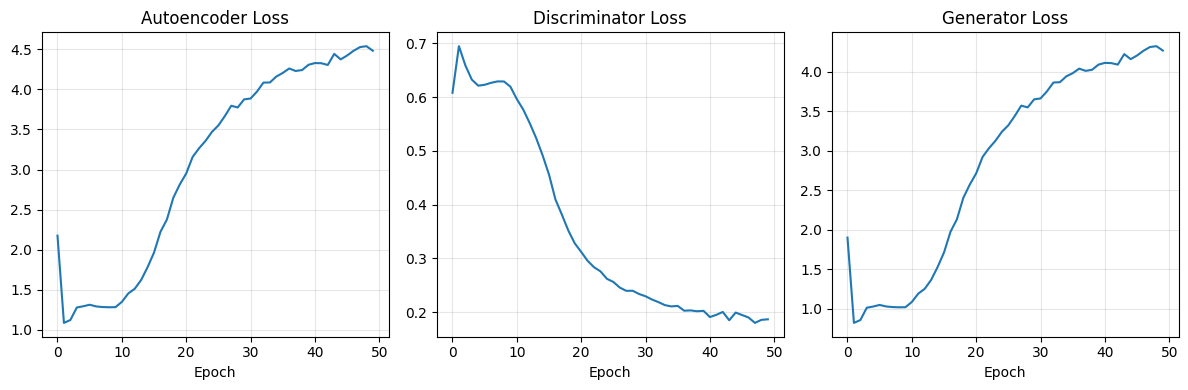

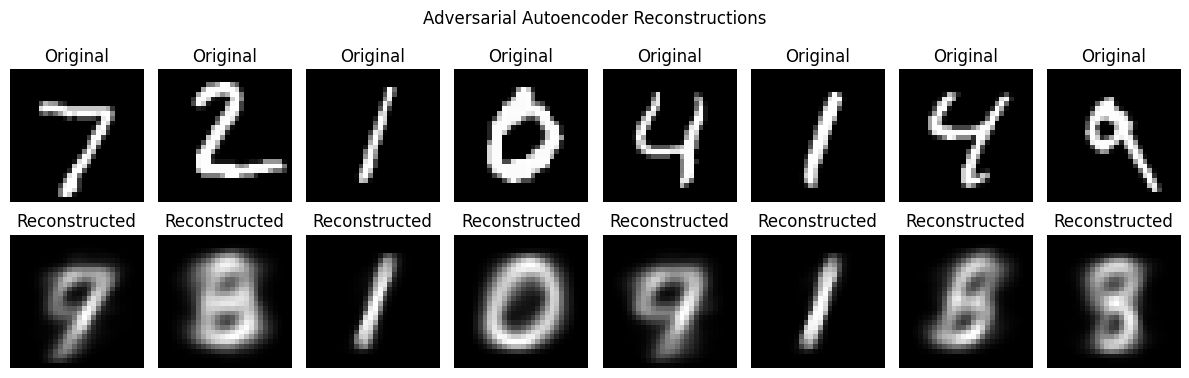

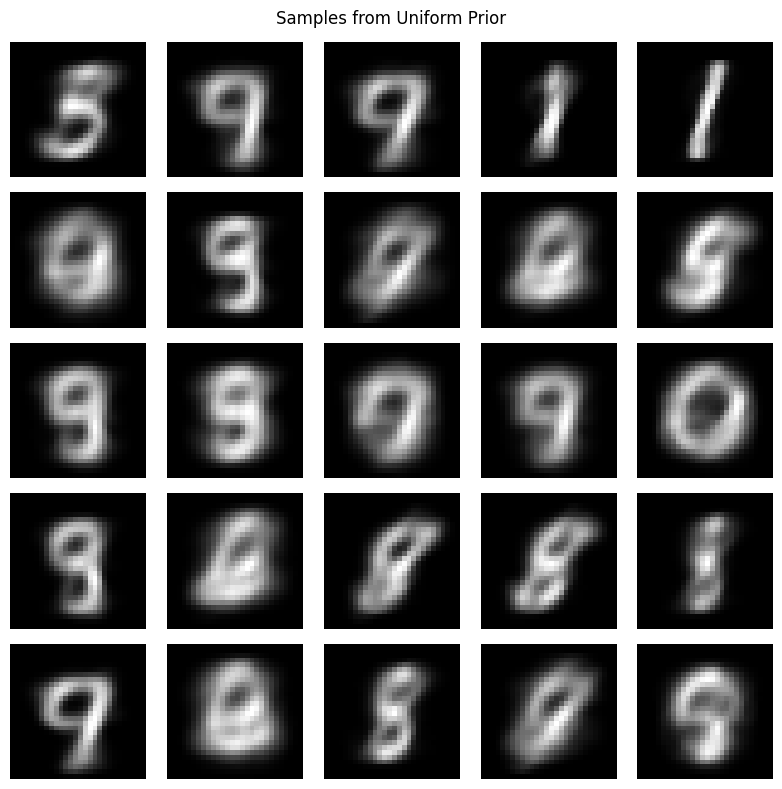

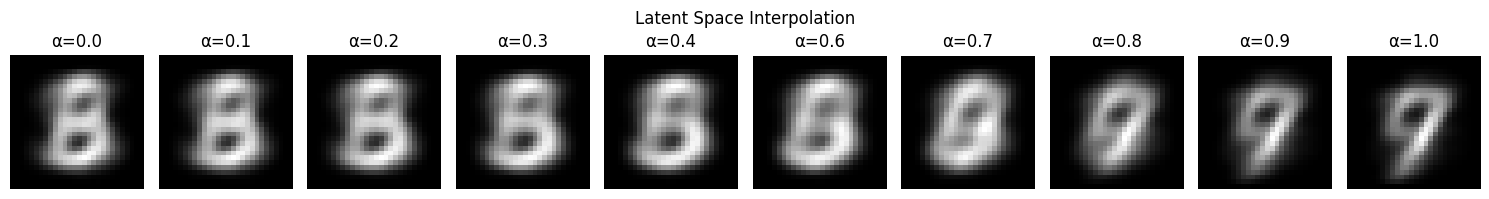

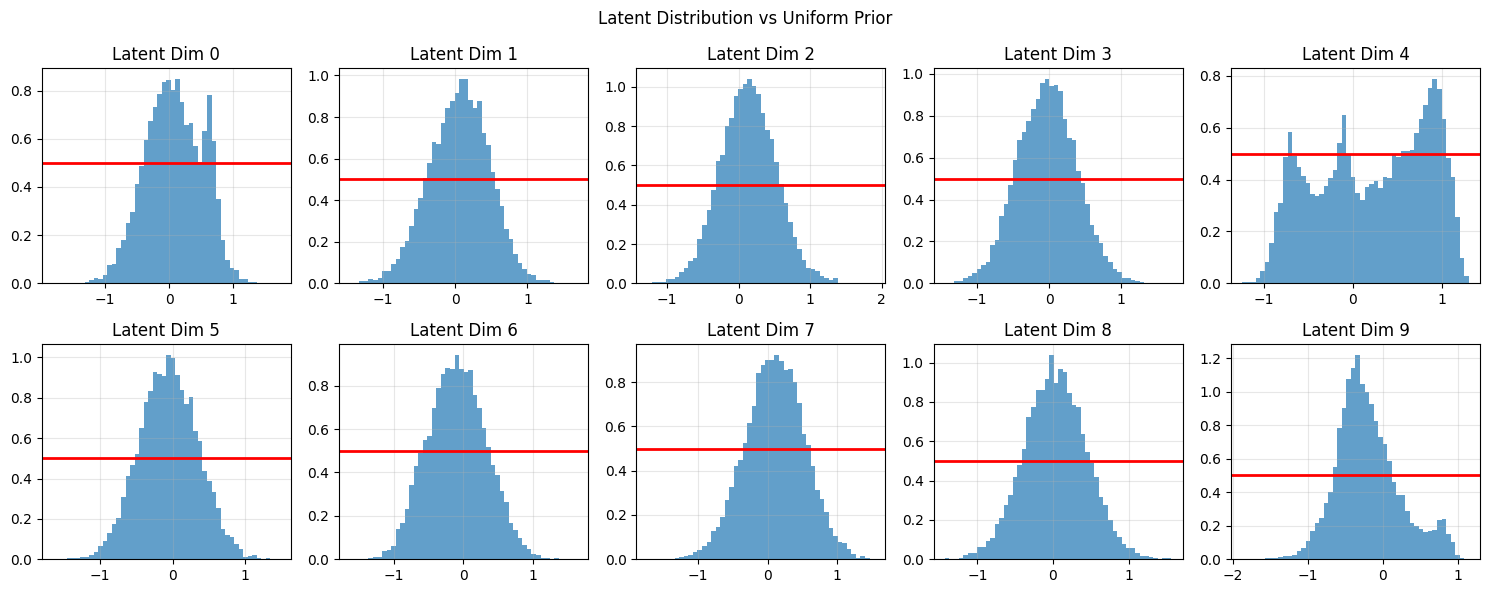

Latent Distribution Statistics:
Mean: tensor([ 0.0816,  0.0576,  0.1363, -0.0304,  0.2176, -0.0524, -0.0927,  0.1017,
         0.0311, -0.1937, -0.0927, -0.0752, -0.0320, -0.0930,  0.1177, -0.1065,
        -0.0772, -0.0267,  0.0018,  0.0198])
Std: tensor([0.4412, 0.4135, 0.3869, 0.4093, 0.6193, 0.4014, 0.4213, 0.4278, 0.4123,
        0.4301, 0.4400, 0.5105, 0.3997, 0.4641, 0.4272, 0.5506, 0.4445, 0.4424,
        0.4085, 0.5469])


In [7]:
def main():
    """Main function to train Adversarial Autoencoder"""

    # Load MNIST dataset
    transform = transforms.Compose([transforms.ToTensor()])

    train_dataset = torchvision.datasets.MNIST(
        root='./data', train=True, download=True, transform=transform
    )
    test_dataset = torchvision.datasets.MNIST(
        root='./data', train=False, download=True, transform=transform
    )

    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

    print(f"Training samples: {len(train_dataset)}")
    print(f"Test samples: {len(test_dataset)}")

    # Experiment with different priors
    priors = ['gaussian', 'uniform']

    for prior in priors:
        print(f"\n{'='*60}")
        print(f"Training Adversarial Autoencoder with {prior} prior")
        print(f"{'='*60}")

        # Initialize model
        aae = AdversarialAutoencoder(
            input_dim=784,
            hidden_dim=400,
            latent_dim=20,
            prior_type=prior
        )

        # Train
        ae_losses, disc_losses, gen_losses = train_adversarial_autoencoder(
            aae, train_loader, epochs=50, lr=1e-3
        )

        # Plot training curves
        plot_training_curves(ae_losses, disc_losses, gen_losses)

        # Visualize results
        visualize_reconstructions(aae, test_loader)
        visualize_prior_generation(aae)
        latent_space_interpolation(aae, test_loader)
        analyze_latent_distribution(aae, test_loader)

if __name__ == "__main__":
    main()

Interpreting the result with both gaussian and uniform prior, for gaussian prior, AEE has reached adversarial equilibrium i.e
*   Discriminator is confused (can't tell real from fake)
*   Generator/Encoder is successfully matching the prior distribution
*   Autoencoder maintains good reconstruction quality

in uniform prior discriminator is too dominating the generator.




